# Adult Census Income Classification - Ludwig API

We recommend using a GPU runtime for this example. In the Colab menu bar, choose Runtime > Change Runtime Type and choose GPU under Hardware Accelerator.

In this notebook, we will show how to use the Ludwig CLI to:

1. Download a Dataset
1. Train a Ludwig Model
1. Evaluate the trained model
1. Visualize training and test metrics
1. Make predictions on New Data

In [1]:
# TODO:  revert to ludwig-ai repo when issue #1885 fixed
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
#!python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet

!python -m pip install git+https://github.com/jimthompson5802/ludwig.git@fix-iss1885-roc-curve-viz-error  --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 136 kB 7.1 MB/s 
     |████████████████████████████████| 398 kB 36.4 MB/s 
     |████████████████████████████████| 47 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 44.7 MB/s 
     |████████████████████████████████| 271 kB 42.5 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 144 kB 52.1 MB/s 


# Download Dataset

[Adult Census Income](https://archive.ics.uci.edu/ml/datasets/adult) is an extract of 1994 Census data for predicting whether a person's income exceeds $50K per year.  The data set consists of over 49K records with 14 attributes with missing data.


The columns in the dataset are

| column         | description                                                  |
|----------------|--------------------------------------------------------------|
| age            | numeric variable, age of person                              |
| workclass      | categorical variable, Type of empolyment                     |
| fnlwgt         | numeric variable, no defintion                               |
| education      | categorical variable, education level                        |
| education-num  | nmeric variable, no definition                               |
| marital-status | categorical variable, marital status                         |
| occupation     | categorical variable, occupation                             |
| relationship   | categorical variable, Relationship to household              |
| race           | categorical variable, race                                   |
| sex            | categorical variable, gender                                 |
| capital-gain   | numeric variable, no definition                              |
| capital-loss   | numeric variable, no definition                              |
| hours-per-week | numeric variable, hours worked per week                      |
| native-country | categorical variable, Country of origin                      |
| income         | binary variable, " <=50K" or " >50K"                         |
| split          | numeric variable, indicating data split training(0), test(2) |


In [2]:
from ludwig.datasets import adult_census_income

# Loads the dataset as a pandas.DataFrame
train_df, test_df, _ = adult_census_income.load(split=True)

NumExpr defaulting to 2 threads.


## Display sample training and testdata

In [3]:
import pandas as pd
import numpy as np

# setup pandas output options
pd.set_option('display.max_colwidth', 100)

# make reproducible output sample
np.random.seed(31)

# Print sample of trainig and test data sets.
print(f"Training Dataset(train_df):\n{train_df.sample(n=5)}")
print(f"\nTest Dataset(test_df):\n{test_df.sample(n=5)}")

Training Dataset(train_df):
       age   workclass  fnlwgt     education  education-num  \
24279   59   State-gov  349910     Bachelors             13   
8364    43           ?  142030       HS-grad              9   
25546   41     Private  207779       HS-grad              9   
6173    79     Private  120707     Doctorate             16   
29227   40   State-gov  141858   Prof-school             15   

            marital-status        occupation    relationship    race      sex  \
24279   Married-civ-spouse   Exec-managerial         Husband   White     Male   
8364              Divorced                 ?       Unmarried   White   Female   
25546            Separated     Other-service   Not-in-family   White   Female   
6173    Married-civ-spouse    Prof-specialty         Husband   White     Male   
29227   Married-civ-spouse    Prof-specialty         Husband   White     Male   

       capital-gain  capital-loss  hours-per-week  native-country  income  
24279         10605           

# Train

## Define ludwig config and create Ludwig model object

In [4]:
import logging
from ludwig.api import LudwigModel

# define model configuration
config = {'combiner': {'dropout': 0.2,
              'num_fc_layers': 3,
              'output_size': 128,
              'type': 'concat'},
 'input_features': [{'name': 'age', 'type': 'number'},
                    {'name': 'workclass', 'type': 'category'},
                    {'name': 'fnlwgt', 'type': 'number'},
                    {'name': 'education', 'type': 'category'},
                    {'name': 'education-num', 'type': 'number'},
                    {'name': 'marital-status', 'type': 'category'},
                    {'name': 'occupation', 'type': 'category'},
                    {'name': 'relationship', 'type': 'category'},
                    {'name': 'race', 'type': 'category'},
                    {'name': 'sex', 'type': 'category'},
                    {'name': 'capital-gain', 'type': 'number'},
                    {'name': 'capital-loss', 'type': 'number'},
                    {'name': 'hours-per-week', 'type': 'number'},
                    {'name': 'native-country', 'type': 'category'}],
 'output_features': [{'name': 'income',
                      'num_fc_layers': 4,
                      'output_size': 32,
                      'preprocessing': {'fallback_true_label': ' >50K'},
                      'loss': {'type': 'binary_weighted_cross_entropy'},
                      'type': 'binary'}],
 'preprocessing': {'number': {'missing_value_strategy': 'fill_with_mean',
                              'normalization': 'zscore'}},
 'trainer': {'epochs': 10, 'optimizer': {'type': 'adam'}}}

# instantiate Ludwig model object
model = LudwigModel(config=config, logging_level=logging.INFO)

import ray failed with exception: No module named 'ray'


# Train the model

In [5]:
# Trains the model. This cell might take a few minutes.
train_stats, preprocessed_data, output_directory = model.train(training_set=train_df,
                                                               test_set=test_df)


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ ludwig_version   │ '0.5rc2'                                                                                │
├──────────────────┼─────────

# Evaluate

In [6]:
# Extract subset of test data for evaluation due to limitations in amount of data displayable in colab notebook.
np.random.seed(13)
eval_df = test_df.sample(n=1000)

In [7]:
eval_df.head()

Training: 100%|██████████| 2550/2550 [00:48<00:00, 52.35it/s] 


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
36727,54,Private,192226,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,>50K
35188,40,Self-emp-not-inc,29702,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,85,United-States,<=50K
34937,35,Private,106471,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,<=50K
36348,26,Private,318644,HS-grad,9,Never-married,Sales,Own-child,White,Male,0,0,35,United-States,<=50K
45149,22,Private,157541,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,50,United-States,<=50K


In [8]:
# Generates predictions and performance statistics for the test set.
test_stats, predictions, output_directory = model.evaluate(
  eval_df,
  collect_predictions=True,
  collect_overall_stats=True,
  skip_save_eval_stats=False,
  skip_save_predictions=False,
  output_directory="test_results",
  return_type="dict"
)

Evaluation: 100%|██████████| 8/8 [00:00<00:00, 185.33it/s]

===== income =====
accuracy: 0.7919999957084656
average_precision_macro: 0.29491866028708136
average_precision_micro: 0.29491866028708136
average_precision_samples: 0.29491866028708136
loss: 7701.5830078125
overall_stats: { 'avg_f1_score_macro': 0.5245714285714286,
  'avg_f1_score_micro': 0.792,
  'avg_f1_score_weighted': 0.7185462857142857,
  'avg_precision_macro': 0.8714445064138316,
  'avg_precision_micro': 0.792,
  'avg_precision_weighted': 0.792,
  'avg_recall_macro': 0.545404963185165,
  'avg_recall_micro': 0.792,
  'avg_recall_weighted': 0.792,
  'kappa_score': 0.13321776236831584,
  'token_accuracy': 0.792}
per_class_stats: {False: {   'accuracy': 0.792,
    'f1_score': 0.8811428571428571,
    'fall_out': 0.9078947368421053,
    'false_discovery_rate': 0.2116564417177914,
    'false_negative_rate': 0.0012953367875647714,
    'false_negatives': 1,
    'false_omission_rate': 0.045454545454545414,
    'false_positive_rate

In [9]:
pred_df = pd.read_parquet("test_results/predictions.parquet")
pred_df.head()

,income_probabilities,income_predictions,income_probabilities_ <=50K,income_probabilities_ >50K,income_probability
0,"[1.0, 0.0]",<=50K,1.0,0.0,1.0
1,"[1.0, 0.0]",<=50K,1.0,0.0,1.0
2,"[1.0, 0.0]",<=50K,1.0,0.0,1.0
3,"[1.0, 0.0]",<=50K,1.0,0.0,1.0
4,"[1.0, 0.0]",<=50K,1.0,0.0,1.0


In [10]:
model2 = LudwigModel.load('results/api_experiment_run/model')

# Generates predictions and performance statistics for the test set.
test_stats2, predictions2, output_directory2 = model2.evaluate(
  eval_df,
  collect_predictions=True,
  collect_overall_stats=True,
  skip_save_eval_stats=False,
  skip_save_predictions=False,
  output_directory="test_results2",
  return_type="dict"
)

pd.read_parquet("test_results2/predictions.parquet").head()

,income_probabilities,income_predictions,income_probabilities_ <=50K,income_probabilities_ >50K,income_probability
0,"[1.0, 0.0]",<=50K,1.0,0.0,1.0
1,"[1.0, 0.0]",<=50K,1.0,0.0,1.0
2,"[1.0, 0.0]",<=50K,1.0,0.0,1.0
3,"[1.0, 0.0]",<=50K,1.0,0.0,1.0
4,"[1.0, 0.0]",<=50K,1.0,0.0,1.0


In [11]:
# Extract subset of test data for evaluation due to limitations in amount of data displayable in colab notebook.
np.random.seed(13)
test_df.sample(n=1000).to_csv('evaluation_dataset.csv', index=False)

In [12]:
%%capture capt
# Generates predictions and performance statistics for the test set.
!ludwig evaluate --model_path results/api_experiment_run/model \
                 --dataset evaluation_dataset.csv \
                 --output_directory test_results3

In [13]:
pred3 = pd.read_parquet("test_results3/predictions.parquet")
pred3.head()

,income_probabilities,income_predictions,income_probabilities_ <=50K,income_probabilities_ >50K,income_probability
0,"[0.418786883354187, 0.581213116645813]",>50K,0.418787,0.581213,0.581213
1,"[0.7777636051177979, 0.22223639488220215]",<=50K,0.777764,0.222236,0.777764
2,"[0.7645255476236343, 0.23547445237636566]",<=50K,0.764526,0.235474,0.764526
3,"[0.9857321968302131, 0.01426780316978693]",<=50K,0.985732,0.014268,0.985732
4,"[0.988319487310946, 0.011680512689054012]",<=50K,0.988319,0.011681,0.988319


# Visualize Metrics

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
pd.DataFrame(predictions['income']['probabilities']).describe()

,0,1
count,1000.000000,1000.000000
mean,0.978000,0.022000
std,0.146757,0.146757
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


## ROC Curve

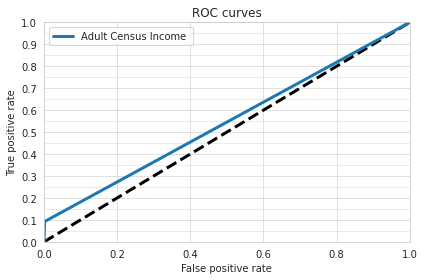

In [16]:
from ludwig.visualize import roc_curves

roc_curves(
    [predictions['income']['probabilities']],
    eval_df['income'],
    preprocessed_data[-1],
    'income',
    '1',
    model_names=["Adult Census Income"],
    output_directory='visualization',
    file_format='png'
)